In [1]:
%matplotlib inline


# Pulsar analysis

Produce a phasogram, phased-resolved maps and spectra for pulsar analysis.
 
## Introduction

This notebook shows how to do a simple pulsar analysis with Gammapy. We will produce a
phasogram, a phase-resolved map and a phase-resolved spectrum of the Vela pulsar. In
order to build these products, we will use the
`~gammapy.makers.PhaseBackgroundMaker` which takes into account the on and off phase to compute a
`~gammapy.datasets.MapDatasetOnOff` and a `~gammapy.datasets.SpectrumDatasetOnOff` in the phase space.

This tutorial uses a simulated run of vel observation from the CTA DC1, which already contains a
column for the pulsar phases. The phasing in itself is therefore not show here. It
requires specific packages like Tempo2 or [PINT](https://nanograv-pint.readthedocs.io)_. A gammapy
recipe shows how to compute phases with PINT in the framework of Gammapy.



## Opening the data

Let’s first do the imports and load the only observation containing Vela
in the CTA 1DC dataset shipped with Gammapy.


In [2]:
# Remove warnings
import warnings
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import ascii
import matplotlib.pyplot as plt
import pandas as pd

# %matplotlib inline
from IPython.display import display
from gammapy.data import DataStore, EventList
from gammapy.datasets import Datasets, FluxPointsDataset, MapDataset, SpectrumDataset
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator
from gammapy.makers import (
    MapDatasetMaker,
    PhaseBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.stats import WStatCountsStatistic
from gammapy.utils.regions import SphericalCircleSkyRegion, CircleSkyRegion

from pathlib import Path
from astroquery.simbad import Simbad


warnings.filterwarnings("ignore")

In [3]:
import gammapy
gammapy.__file__

'/homes/wang/swong/.local/lib/python3.9/site-packages/gammapy/__init__.py'

## Check setup



Load the data store (which is a subset of CTA-DC1 data):



In [4]:
# data_store = DataStore.from_dir("/Users/dinahibrahim/Desktop/SUMMER_2024_RESEARCH/Code/Data/dl3_fullenclosure_supersoftNN2tel_runwise", hdu_table_filename="hdu-index-crab.fits.gz")

data_store = DataStore.from_dir("/raid/romulus/swong/mydl3/crabpsr2024_runwise/", hdu_table_filename="hdu-index-crab.fits.gz")

Define observation ID and print events:



In [5]:
id_list,event,phase = np.genfromtxt(Path('/raid/romulus/swong/CrabTempo2WithJodrell/crab_phases_TEMPO2.csv'),delimiter=',',usecols=(0,1,2),unpack=True,dtype=(int,int,float)) 

obs_list_crab = data_store.get_observations(skip_missing = True, required_irf = "point-like")
# print(obs_list_crab)

# print(len(obs_list_crab))
# print(obs_list_crab[10].events)

Now that we have our observation, let’s select the events in 0.12° radius (super soft cuts)
around the pulsar position.



In [239]:
pos_target = SkyCoord(SkyCoord(ra=83.633114, dec=22.014487, unit="deg", frame="icrs"))
on_radius = 0.2*u.deg #0.0894427191 * u.deg
on_region = SphericalCircleSkyRegion(pos_target, on_radius)


# Apply angular selection
from gammapy.data import EventList

events_crab = obs_list_crab[0].events.select_region(on_region)

# stack dataset when more than one run
for obs in obs_list_crab[1:]: 
    events_crab.stack(obs.events.select_region(on_region))

Let’s load the phases of the selected events in a dedicated array.



In [241]:
phases = events_crab.table["PHASE"]

In [9]:
# events_table

## Phasogram

Once we have the phases, we can make a phasogram. A phasogram is a
histogram of phases. It works exactly like any other histogram (you
can set the binning, evaluate the errors based on the counts in each
bin, etc).



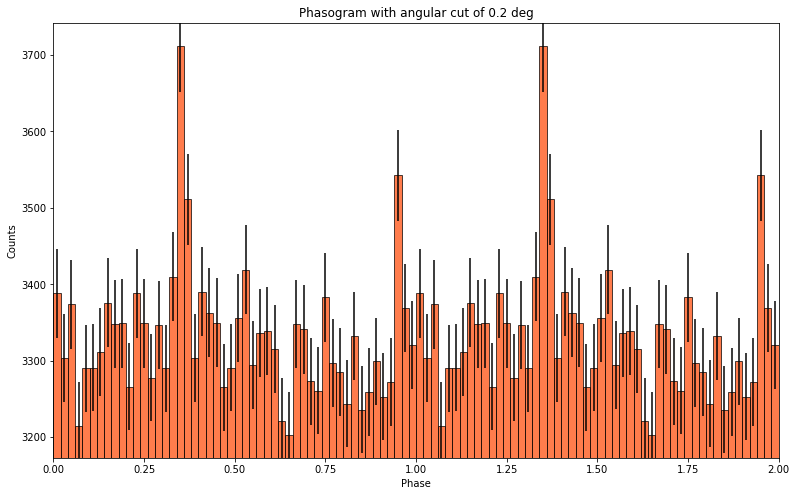

In [242]:
from astropy.table import Table, vstack

nbins = 50
phase_min, phase_max = (0, 1)
values, bin_edges = np.histogram(phases, range=(phase_min, phase_max), bins=nbins)

bin_width = (phase_max - phase_min) / nbins

bin_center = (bin_edges[:-1] + bin_edges[1:]) / 2

# Poissonian uncertainty on each bin
values_err = np.sqrt(values)

# double the range to show phases from 0 to 2
values_double = values.copy()
values_err_double = values_err.copy()
bin_center_double = bin_center.copy() + 1


nbins_full = nbins * 2
values_full = np.concatenate([values, values_double])
values_err_full = np.concatenate([values_err, values_err_double])
bin_center_full = np.concatenate([bin_center, bin_center_double])
bin_width_full = ((phase_max + 1) - phase_min) / nbins_full


fig, ax = plt.subplots(figsize=(13, 8))
ax.bar(
    x=bin_center_full,
    height=values_full,
    width=bin_width_full,
    color="orangered",
    alpha=0.7,
    edgecolor="black",
    yerr=values_err_full,
)
ax.set_xlim(0, 2)
ax.set_ylim(np.amin(values) - 30 ,np.amax(values) + 30)
ax.set_xlabel("Phase")
ax.set_ylabel("Counts")
ax.set_title(f"Phasogram with angular cut of {on_radius}")
# plt.figure(figsize = (11, 3))
# plt.savefig("Figures/Phasogram_supersoft_crabV6_multiple_ephemeris_above120GeV.png", bbox_inches='tight')
plt.show()

# double the range to have it from 0 to 2


Now let’s add some fancy additions to our phasogram: a patch on the ON-
and OFF-phase regions and one for the background level.



In [243]:
on_phase_range = (0.33, 0.36)
off_phase_range = (0.5, 0.9)
#on_phase_range = (0.5, 0.7)
#off_phase_range = (0.1, 0.3)
# Evaluate background level
mask_off = (off_phase_range[0] < np.array(phases)) & (np.array(phases) < off_phase_range[1])

count_bkg = mask_off.sum()
print(f"Number of Off events: {count_bkg}")

# bkg level normalized by the size of the OFF zone (0.3)
bkg = count_bkg / nbins / (off_phase_range[1] - off_phase_range[0])

# error on the background estimation
bkg_err = np.sqrt(count_bkg) / nbins / (off_phase_range[1] - off_phase_range[0])

Number of Off events: 66041


Let's redo the same plot for the basis



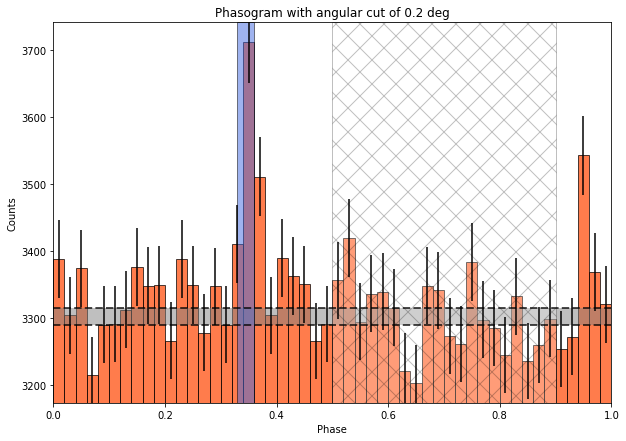

In [244]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(
    x=bin_center_full,
    height=values_full,
    width=bin_width_full,
    color="orangered",
    alpha=0.7,
    edgecolor="black",
    yerr=values_err_full,
)

# Plot background level
x_bkg = np.linspace(0, 2, 50)

kwargs = {"color": "black", "alpha": 0.7, "ls": "--", "lw": 2}

ax.plot(x_bkg, (bkg - bkg_err) * np.ones_like(x_bkg), **kwargs)
ax.plot(x_bkg, (bkg + bkg_err) * np.ones_like(x_bkg), **kwargs)

ax.fill_between(
    x_bkg, bkg - bkg_err, bkg + bkg_err, facecolor="grey", alpha=0.5
)  # grey area for the background level

# Let's make patches for the on and off phase zones
on_patch = ax.axvspan(
    on_phase_range[0], on_phase_range[1], alpha=0.5, color="royalblue", ec="black"
)

off_patch = ax.axvspan(
    off_phase_range[0],
    off_phase_range[1],
    alpha=0.25,
    color="white",
    hatch="x",
    ec="black",
)

# Legends "ON" and "OFF"
# ax.text(0.18, 5, "ON", color="black", fontsize=17, ha="center")
# ax.text(0.63, 5, "OFF", color="black", fontsize=17, ha="center")
ax.set_xlabel("Phase")
ax.set_ylabel("Counts")
ax.set_xlim(0, 1)
ax.set_ylim(np.amin(values) - 30 ,np.amax(values) + 30)
ax.set_title(f"Phasogram with angular cut of {on_radius}")
#plt.savefig("Figures/PhasogramCrab_1000000_v1")
plt.show()

## Make a Li&Ma test over the events

Another thing that we want to do is to compute a Li&Ma test between the on-phase and the off-phase.



In [245]:
# Calculate the ratio between the on-phase and the off-phase
alpha = (on_phase_range[1] - on_phase_range[0]) / (
    off_phase_range[1] - off_phase_range[0]
)

# Select events in the on region
# region_events = obs_list_crab[0].events.select_region(on_region)

# Select events in phase space
on_events = events_crab.select_parameter("PHASE", band=on_phase_range)
off_events = events_crab.select_parameter("PHASE", band=off_phase_range)

# Apply the WStat (Li&Ma statistic)
pulse_stat = WStatCountsStatistic(
    len(on_events.time), len(off_events.time), alpha=alpha
)

print(f"Number of excess counts: {pulse_stat.n_sig}")
print(f"TS: {pulse_stat.ts}")
print(f"Significance: {pulse_stat.sqrt_ts}")

Number of excess counts: 470.92500000000473
TS: 40.3022071341984
Significance: 6.348401935463633


## Phase-resolved map



Now that we have an overview of the phasogram of the pulsar, we can do a phase-resolved sky map
: a map of the ON-phase events minus alpha times the OFF-phase events.
Alpha is the ratio between the size of the ON-phase zone (here 0.1) and
the OFF-phase zone (0.3).



In [246]:
e_true = MapAxis.from_energy_bounds(
    0.001, 30, 6, per_decade=True, unit="TeV", name="energy_true"
)
e_reco = MapAxis.from_energy_bounds(
    0.01, 30, 4, per_decade=True, unit="TeV", name="energy"
)

geom = WcsGeom.create(
    binsz=0.02 * u.deg, skydir=pos_target, width="4 deg", axes=[e_reco]
)

Let’s create an ON-map and an OFF-map:



In [249]:
from tqdm.auto import tqdm
map_dataset_empty = MapDataset.create(geom=geom, energy_axis_true=e_true)

map_dataset_maker = MapDatasetMaker()
phase_bkg_maker = PhaseBackgroundMaker(
    on_phase=on_phase_range, off_phase=off_phase_range, phase_column_name="PHASE",
)

offset_max = 1.5 * u.deg
safe_mask_maker = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)

map_datasets = Datasets()

for obs in tqdm(obs_list_crab):
    # print(obs)
    #print(obs.events.table)
    map_dataset = map_dataset_maker.run(map_dataset_empty, obs)
    map_dataset = safe_mask_maker.run(map_dataset, obs)
    map_dataset_on_off = phase_bkg_maker.run(map_dataset, obs)
    map_datasets.append(map_dataset_on_off)

# datasets_stacked = map_datasets.stack_reduce()

  0%|          | 0/137 [00:00<?, ?it/s]

The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta informa

The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta informa

Once the data reduction is done, we can plot the map of the counts-ON (i.e. in the ON-phase)
and the map of the background (i.e. the counts-OFF, selected in the OFF-phase, multiplied by alpha).
If one wants to plot the counts-OFF instead, `~background` should be replaced by `~counts_off` in the following cell.



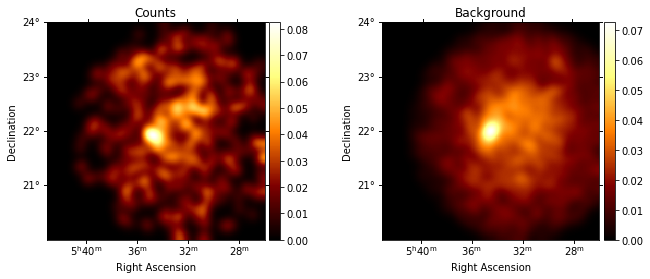

In [263]:
counts = (
    map_datasets[0].counts.smooth(kernel="gauss", width=0.1 * u.deg).sum_over_axes()
)
background = (
    map_datasets[0].background.smooth(kernel="gauss", width=0.1 * u.deg).sum_over_axes()
)

fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 4), ncols=2, subplot_kw={"projection": counts.geom.wcs}
)

counts.plot(ax=ax1, add_cbar=True)
ax1.set_title("Counts")

background.plot(ax=ax2, add_cbar=True)
ax2.set_title("Background")

# plt.savefig("Figures/PhaseMapCrab_Run100000_v1")

plt.show()

Finally, we can run an `~gammapy.estimators.ExcessMapEstimator` to compute the excess and significance maps.



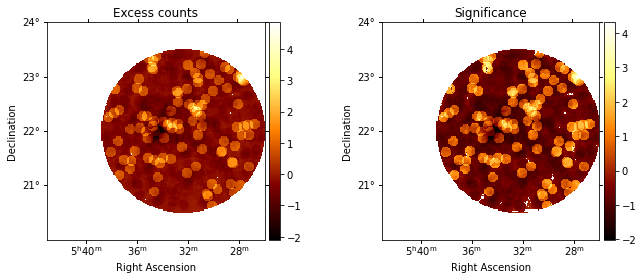

In [264]:
excess_map_estimator = ExcessMapEstimator(
    correlation_radius=np.sqrt(0.008)*u.deg, energy_edges=[0.01 * u.TeV, 0.4 * u.TeV] # keep 0.08 fixed
)
estimator_results = excess_map_estimator.run(dataset=map_datasets[4])

npred_excess = estimator_results.npred_excess
sqrt_ts = estimator_results.sqrt_ts

fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 4), ncols=2, subplot_kw={"projection": npred_excess.geom.wcs}
)

npred_excess.plot(ax=ax1, add_cbar=True)
ax1.set_title("Excess counts")

sqrt_ts.plot(ax=ax2, add_cbar=True)
ax2.set_title("Significance")

plt.show()

Note that here we are lacking statistic because we only use one run of CTA.

## Phase-resolved spectrum

We can also make a phase-resolved spectrum.
In order to do that, we are going to use the `~gammapy.makers.PhaseBackgroundMaker` to create a
`~gammapy.datasets.SpectrumDatasetOnOff` with the ON and OFF taken in the phase space.
Note that this maker take the ON and OFF in the same spatial region.

Here to create the `~gammapy.datasets.SpectrumDatasetOnOff`, we are going to redo the whole data reduction.
However, note that one can use the `~gammapy.datasets.MapDatasetOnOff.to_spectrum_dataset()` method
(with the `containment_correction` parameter set to True) if such a `~gammapy.datasets.MapDatasetOnOff`
has been created as shown above.



In [265]:
e_true = MapAxis.from_energy_bounds(0.01, 100, 200, unit="TeV", name="energy_true")
e_reco = MapAxis.from_energy_bounds(0.01, 1, 30, unit="TeV", name="energy")


geom = RegionGeom.create(region=on_region, axes=[e_reco])
spectrum_dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=e_true)

spectrum_dataset_maker = SpectrumDatasetMaker()
phase_bkg_maker = PhaseBackgroundMaker(
    on_phase=on_phase_range, off_phase=off_phase_range, phase_column_name="PHASE"
)

offset_max = 5 * u.deg
safe_mask_maker = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)

spectrum_datasets = Datasets()

for obs in obs_list_crab:
    spectrum_dataset = spectrum_dataset_maker.run(spectrum_dataset_empty, obs)
    spectrum_dataset = safe_mask_maker.run(spectrum_dataset, obs)
    spectrum_dataset_on_off = phase_bkg_maker.run(spectrum_dataset, obs)
    spectrum_datasets.append(spectrum_dataset_on_off)

The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta informa

The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta information will be empty here.
The meta informa

Now let’s take a look at the datasets we just created:



Now we’ll fit a model to the spectrum with the `~gammapy.modeling.Fit` class. First we
load a power law model with an initial value for the index and the
amplitude and then wo do a likelihood fit. The fit results are printed
below.



In [269]:
spectral_model = PowerLawSpectralModel(
    index=3.8, amplitude=4.2e-11 * u.Unit("1 / (cm2 s TeV)"), reference=0.15 * u.TeV)
model = SkyModel(spectral_model=spectral_model, name="crab")
emin_fit, emax_fit = (0.05 * u.TeV, 1 * u.TeV)

#mask_fit = geom.energy_mask(energy_min=emin_fit, energy_max=emax_fit)

for dataset in spectrum_datasets:
    dataset.models = model
    #dataset.mask_fit = mask_fit
joint_fit = Fit()
joint_result = joint_fit.run(datasets=spectrum_datasets)

print(joint_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 46
	total stat : 1972.08

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [270]:
dataset_stacked_spec = Datasets(spectrum_datasets).stack_reduce()
dataset_stacked_spec.models = model
stacked_fit = Fit()
result_stacked = stacked_fit.run([dataset_stacked_spec])

# Make a copy to compare later
model_best_stacked = model.copy()

print(result_stacked)
print(model_best_stacked)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 30
	total stat : 16.20

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

SkyModel

  Name                      : DqtRVAFp
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      3.352   +/-    0.63             
    amplitude                     :   1.24e-11   +/- 3.0e-12 1 / (TeV s cm2)
    reference             (frozen):      0.150       TeV         




In [271]:
model

SkyModel(spatial_model=None, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7f96a3fd0fd0>)temporal_model=None)

Now you might want to do the stacking here even if in our case there is
only one observation which makes it superfluous. We can compute flux
points by fitting the norm of the global model in energy bands.



In [272]:
energy_edges = np.logspace(-1,0,10) * u.TeV

stack_dataset = spectrum_datasets.stack_reduce()

stack_dataset.models = model

fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab", selection_optional="all"
)

flux_points = fpe.run(datasets=[stack_dataset])
flux_points.meta["ts_threshold_ul"] = 2

# amplitude_ref = 0.57 * 19.4e-14 * u.Unit("1 / (cm2 s MeV)")
spec_model_true = PowerLawSpectralModel(
    index=3.8, amplitude=4.2e-11 * u.Unit("1 / (cm2 s TeV)"), reference=0.15 * u.TeV)

spec_model_true.amplitude.error = 2.4e-11
spec_model_true.index.error = 0.54


flux_points_dataset = FluxPointsDataset(data=flux_points, models=model)

In [273]:
flux_points.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,float64[11],bool,float64[1],bool,float64[11]
0.11659144011798316,0.09999999999999998,0.13593563908785253,2.8911956739417116e-11,1.0575382728202355e-12,1.2152906045594899e-13,0.6934372876721185,0.42953496953863973,0.42455287990144547,0.4345606893224288,1.5725235320384479,2.7067629292141646,1.6452242793048504,661.0111251243851,42.936943,2.0037987269461155e-07,2.7067631295940373,1.3549523860856425 .. 81.63589864625828,True,661.0,True,0.2 .. 4.999999999999999
0.1467799267622069,0.13593563908785253,0.15848931924611132,1.3361079184144514e-11,3.0268411263530535e-13,4.42668747955366e-14,1.5884211638376196,0.4902708647486707,0.4842096597975174,0.4964846031346659,2.5950441105385087,11.442137477715733,3.3826228695667115,581.9432887339929,80.63905,5.883484845981002e-06,11.442143361200579,8.647401933019864 .. 41.25094951847859,False,582.0,True,0.2 .. 4.999999999999999
0.18478497974222904,0.15848931924611132,0.21544346900318834,6.174553959594052e-12,3.5795150979735014e-13,6.519409264107674e-14,0.6196923302498287,0.4271568051078906,nan,0.4316749143436519,1.4918753574527004,2.169129452187917,1.4727964734436043,809.7479437177327,42.62905,1.5291067586658755,3.6982362108537927,2.51352305317414 .. 88.11896317523497,True,808.0,True,0.2 .. 4.999999999999999
0.251188643150958,0.21544346900318834,0.29286445646252357,2.2060955921562897e-12,1.7385062987070682e-13,4.3042119463423397e-14,1.6032507655437769,0.6474891334184565,0.639552197450009,0.6555460695326105,2.9312977728678686,6.537102242931724,2.556775751397006,598.9397444288472,62.4601,0.5579530212344253,7.095055264166149,5.5259173843151075 .. 24.926050656496955,False,598.0,True,0.2 .. 4.999999999999999
0.3162277660168379,0.29286445646252357,0.34145488738336005,1.0195026978027579e-12,4.975878886460748e-14,1.5678061741557907e-14,1.0535435862100384,1.2543047878262275,nan,1.2793836777199965,3.6634141862370386,0.7300122663218644,0.8544075528235132,227.99841492337725,13.123359,1.1801603250205517e-08,0.7300122781234677,0.47606621476006694 .. 8.805426458086004,True,228.0,True,0.2 .. 4.999999999999999
0.3981071705534972,0.34145488738336005,0.464158883361278,4.711426624134544e-13,5.884429626881038e-14,2.3089884125154232e-14,-0.3535009264033143,1.192593231080313,nan,1.2118757238729179,2.10941752066457,0.08700040097392048,-0.2949583037887228,346.3947130301466,-5.70067,1.349802741962776,1.4368031429366965,1.5619938033851213 .. 18.971764642607013,True,345.0,True,0.2 .. 4.999999999999999
0.5411695265464637,0.464158883361278,0.6309573444801932,1.6833373837669663e-13,2.857961955914867e-14,1.5244288410961078e-14,0.9369983081992423,1.8920376322536763,nan,1.9280069995269264,4.866142452725181,0.2499827674437256,0.4999827671467544,255.6183969115476,8.164839,0.2507562028076791,0.5007389702514047,0.40479611532282433 .. 4.517459410104493,True,255.0,True,0.2 .. 4.999999999999999
0.6812920690579614,0.6309573444801932,0.7356422544596417,7.779205081431829e-14,8.179937320515309e-15,5.552721331863405e-15,9.059588581166862,4.107996069624728,3.9917216164451688,3.9917216164479115,nan,5.57144021653221,2.3603898441851103,112.99969952533259,24.124687,8.458300726488233e-10,5.57144021737804,5.31103277789407 .. 1.0353989030791126,False,113.0,True,0.2 .. 4.999999999999999


Text(0.5, 1.0, 'TS Profiles')

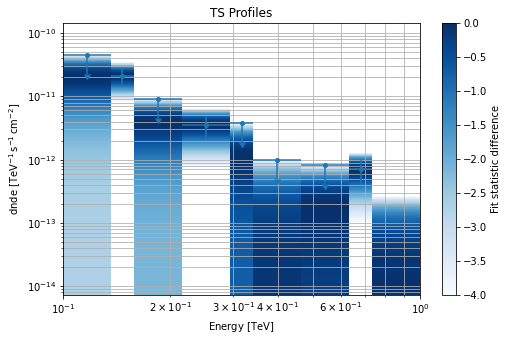

In [274]:
plt.figure(figsize=(8,5))
ax = flux_points.plot(sed_type="dnde")

flux_points.plot_ts_profiles(ax=ax, sed_type="dnde")

plt.grid(which='both')
plt.title('TS Profiles')

Now we can plot.



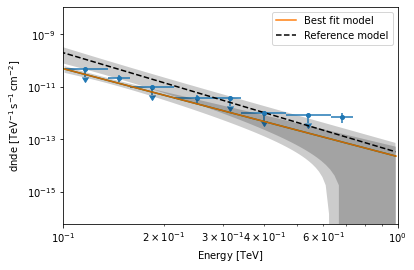

In [262]:
# ax_spectrum, ax_residuals = flux_points_dataset.plot_fit()
ax_spectrum = flux_points_dataset.plot_spectrum(kwargs_fp={'sed_type':'dnde'},kwargs_model={'sed_type':'dnde'})
model_best_stacked.spectral_model.plot(energy_bounds=(emin_fit, emax_fit))
# ax_spectrum.set_ylim([1e-14, 3e-11])
# ax_residuals.set_ylim([-1.7, 1.7])

spec_model_true.plot(
    ax=ax_spectrum,
    energy_bounds=(emin_fit, emax_fit),
    label="Reference model",
    c="black",
    linestyle="dashed",
)
spec_model_true.plot_error(energy_bounds=(emin_fit, emax_fit))

ax_spectrum.legend(loc="best")

#plt.savefig("Figures/PhaseResolvedSpectrumCrab_100000_v1")
plt.show()

This tutorial suffers a bit from the lack of statistics: there were 9
Vela observations in the CTA DC1 while there is only one here. When done
on the 9 observations, the spectral analysis is much better agreement
between the input model and the gammapy fit.

